# BE 5210: Homework 3

Spring 2026  |  68 points

**Due:** Thursday, 02/12/2026 10:00 PM

**Objective:** Extract features from data and build a simple detector.

## 1. Features and Simulations (39 pts)
As you learned in class, features are the backbone of almost all detection strategies, from seizures in EEG to faces in images. Features are usually defined in journal articles as an equation or set of equations, and the
task for the reader is to implement that feature in code. In this section, you will explore and implement some features commonly used in EEG analysis and test them on simulated time-series data.

In [95]:
# Install Pennsieve

%%capture
!wget -q https://github.com/Pennsieve/pennsieve-agent/releases/download/1.8.12/pennsieve_1.8.12_amd64.deb
!sudo dpkg -i pennsieve_1.8.12_amd64.deb > /dev/null
!sudo apt-get install -f -y > /dev/null
!pip install pennsieve --no-deps
!pip install boto3 s3transfer botocore jmespath grpcio_tools --quiet
!rm pennsieve_1.8.12_amd64.deb

In [96]:
# Please uncomment the config code below or upload the config.ini file to /root/.pennsieve
# !pennsieve config wizard

In [97]:
# Set up the notebook environment

%env PENNSIEVE_AGENT_PORT=9002
!pennsieve agent

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal as sig
import datetime
import time

import os,sys
import pandas as pd
from contextlib import contextmanager
from pennsieve import Pennsieve

class PennsieveStreamer:
    """
    A simplified interface for streaming data from Pennsieve.
    """
    def __init__(self, target_port='localhost:9002'):
        """
        Initialize the connection to the Pennsieve Agent.

        Args:
            target_port (str): The address of the local Pennsieve Agent (default: localhost:9002).
        """
        self.ps = None
        self.dataset = None

        try:
            print(f"Connecting to Pennsieve Agent at {target_port}...")

            @contextmanager
            def suppress_stdout():
                with open(os.devnull, "w") as devnull:
                    old_stdout = sys.stdout
                    sys.stdout = devnull
                    try:
                        yield
                    finally:
                        sys.stdout = old_stdout

            with suppress_stdout():
                self.ps = Pennsieve(target=target_port)

            print("Successfully connected to Pennsieve Agent.")
        except Exception as e:
            print(f"Failed to connect to Pennsieve Agent: {e}")
            print("Ensure the Pennsieve Agent is running (run 'pennsieve agent' in terminal).")
            raise e

    def set_dataset(self, dataset_id: str):
        """
        Set the active dataset by ID or dataset name. Resolves the ID to a name if necessary.

        Args:
            dataset_id (str): The Pennsieve Dataset ID (e.g., 'N:dataset:...').
        """
        print(f"Resolving dataset ID: {dataset_id}")
        datasets_dict = self.ps.get_datasets()

        found_name = None
        if isinstance(datasets_dict, dict):
            for name, id_val in datasets_dict.items():
                if id_val == dataset_id or name == dataset_id:
                    print(f"Found dataset: '{name}'")
                    found_name = name
                    break

        if not found_name:
             raise ValueError(f"Dataset with ID {dataset_id} not found in available datasets.")

        target = found_name

        try:
            self.ps.use_dataset(target)
            self.dataset = self.ps.dataset
            print(f"Active dataset set to: {target}")

        except Exception as e:
            print(f"Error setting dataset: {e}")
            raise e

    def map_package_id(self, package_name: str) -> str:
        """
        Map a package name to its ID.

        Args:
            package_name (str): The name of the package.

        Returns:
            str: The ID of the package.
        """
        packages = self.ps.get(f"https://api.pennsieve.io/datasets/{self.ps.dataset}/packages?filename={package_name}.edf",params={"accept": "*/*"})['packages']
        packages = [p['content'] for p in packages if p['content']['state'] == 'READY' ]
        if len(packages) > 1:
            raise ValueError("Multiple packages with the same name identified. Please use package ID instead.")
        package_id = packages[0]['nodeId']
        return package_id

    def set_package(self, package_id: str):
        """
        Set the active dataset by ID or dataset name. Resolves the ID to a name if necessary.

        Args:
            package_id (str): The Pennsieve Package ID (e.g., 'N:package:...').
        """
        if not self.dataset:
            raise ValueError("Dataset not set. Call set_dataset() first.")

        # map package name to ids
        if not package_id.startswith('N:package'):
            package_id = self.map_package_id(package_id)
        self.package_id = package_id
        print(f"Active package set to: {package_id}")

    def get_clip(self, start_sec: float, end_sec: float, channel_list: list = None, relative_time = True) -> pd.DataFrame:
        """
        Stream a data clip for all channels in a package.

        Args:
            start_sec (float): Start time in seconds relative to recording start.
            end_sec (float): End time in seconds relative to recording start.
            channel_list (list, optional): A list of channel names (strings) to retrieve.
                If None, all channels in the package are returned. Defaults to None.
            relative_time (bool, optional): If True, resets the DataFrame index to
                start at 0 (relative to recording start). Defaults to True.

        Returns:
            pd.DataFrame: A DataFrame containing the streamed data.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        # Get channels to get IDs
        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True)

        if not channels:
            print("No channels found in this package.")
            return pd.DataFrame()

        if channel_list is None:
            channel_ids = [c.id for c in channels]
            channel_names = [c.name for c in channels]
        else:
            channel_ids = [c.id for c in channels if c.name in channel_list]
            channel_names = [c.name for c in channels if c.name in channel_list]

            if not channel_ids:
                print("No matching channels found in this package.")
                return pd.DataFrame()

        data = self.ps.timeseries.getRangeForChannels(
            self.dataset,
            self.package_id,
            channel_ids,
            start_sec,
            end_sec,
            False, # force_refresh
            True   # is_relative_time
        )
        data.columns = channel_names
        data = data.sort_index()
        if relative_time:
            ts = self.get_ts_details_from_name(channel_names[0])
            data.index = data.index - ts['start_time']
        return data

    def get_metadata(self) -> dict:
        """
        Retrieve metadata for the package (channels, rates, units).

        Args:
            package_id (str): The ID of the TimeSeries package.

        Returns:
            dict: Metadata including channel count and details (rate, unit, range).
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True) # include_data=True

        metadata = {
            "channel_count": len(channels),
            "channels": []
        }

        for c in channels:
            channel_info = {
                "name": getattr(c, 'name', 'Unknown'),
                "id": getattr(c, 'id', 'Unknown'),
                "rate_hz": getattr(c, 'rate', None),
                "unit": getattr(c, 'unit', None),
                "start_time": getattr(c, 'start_time', None),
                "end_time": getattr(c, 'end_time', None)
            }
            metadata["channels"].append(channel_info)

        return metadata

    def get_channel_labels(self) -> list:
        """
        Get a list of channel labels for a specific package.

        Args:
            package_id (str): The ID of the TimeSeries package.

        Returns:
            list: A list of channel labels.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True) # include_data=True
        return [c.name for c in channels]

    def get_channel_indices(self, channel_list: list) -> list:
        """
        Get a list of channel labels for a specific package.

        Args:
            package_id (str): The ID of the TimeSeries package.

        Returns:
            list: A list of channel labels.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True) # include_data=True
        channel_indices = []
        for e, c in enumerate(channels):
            if c.name in channel_list:
                channel_indices.append(e)
        return channel_indices

    def get_ts_details_from_name(self, channel_name: str) -> dict:
        """
        Get details about a specific channel in a TimeSeries package.

        Args:
            package_id (str): The ID of the TimeSeries package.
            channel_name (str): The name of the channel to retrieve details for.

        Returns:
            dict: Details about the specified channel, including rate, unit,
                  start time, and end time.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True) # include_data=True
        if not channels:
            print("No channels found in this package.")
            return {}
        if channel_name not in [c.name for c in channels]:
            print(f"Channel '{channel_name}' not found in this package.")
            return {}
        indice = self.get_channel_indices([channel_name])[0]
        c = channels[indice]
        channel_info = {
              "name": getattr(c, 'name', 'Unknown'),
              "id": getattr(c, 'id', 'Unknown'),
              "rate_hz": getattr(c, 'rate', None),
              "unit": getattr(c, 'unit', None),
              "start_time": getattr(c, 'start_time', None),
              "end_time": getattr(c, 'end_time', None),
        }
        channel_info['duration'] = channel_info['end_time'] - channel_info['start_time']

        return channel_info

    def get_ts_details_from_indice(self, channel_indice: str) -> dict:
        """
        Get details about a specific channel in a TimeSeries package.

        Args:
            package_id (str): The ID of the TimeSeries package.
            channel_name (str): The name of the channel to retrieve details for.

        Returns:
            dict: Details about the specified channel, including rate, unit,
                  start time, and end time.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        channels = self.ps.timeseries.getChannels(self.dataset, self.package_id, True) # include_data=True
        c = channels[channel_indice]
        channel_info = {
              "name": getattr(c, 'name', 'Unknown'),
              "id": getattr(c, 'id', 'Unknown'),
              "rate_hz": getattr(c, 'rate', None),
              "unit": getattr(c, 'unit', None),
              "start_time": getattr(c, 'start_time', None),
              "end_time": getattr(c, 'end_time', None),
        }
        channel_info['duration'] = channel_info['end_time'] - channel_info['start_time']

        return channel_info

    def get_annotations(self):
        """
        Get annotations for a specific package.

        Args:
            package_id (str): The ID of the TimeSeries package.

        Returns:
            list: A list of annotations.
        """
        if not self.package_id:
            raise ValueError("Package not set. Call set_package() first.")

        annots = self.ps.get(f"https://api.pennsieve.io/packages/{self.package_id}/annotations",params={"accept": "*/*"})['annotations']

        return annots

env: PENNSIEVE_AGENT_PORT=9002
Pennsieve Agent is already running on port: 9002


### 1
Consider the following toy signal: 7 seconds of a 2 Hz sine wave with a quarter period phase-shift, sampled at 100 Hz.

####1a
Plot the signal (2 pts)

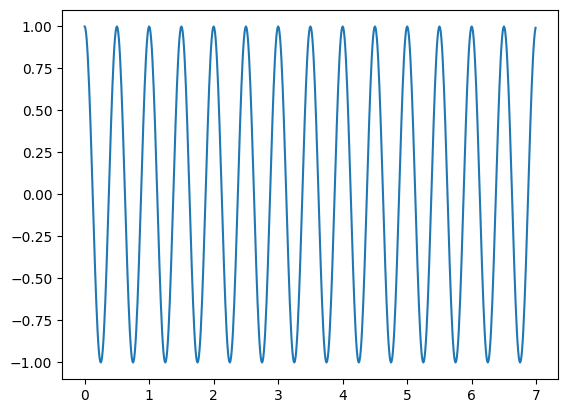

In [98]:
# Your code here
time = np.arange(0, 7, 1/100)
signal = np.sin(2 * np.pi * 2 * time + np.pi / 2)
plt.plot(time, signal)
plt.show()

####1b
Create a function for the line-length feature $LL(x) = \sum_{i=1}^n |x_i - x_{i - 1}|$. This function can be implemented as a (cheeky) one-liner using Numpy. You may find [`np.ediff1d`](https://numpy.org/doc/stable/reference/generated/numpy.ediff1d.html), [`np.sum`](https://numpy.org/doc/stable/reference/generated/numpy.sum.html), and [`np.absolute`](https://numpy.org/doc/stable/reference/generated/numpy.absolute.html) to be helpful. (4 pts)

In [99]:
# Your code here
def line_length(x):
  return np.sum(np.absolute(np.ediff1d(x)))

####1c
What is the line length of this signal? (2 pts)

In [100]:
# Your code here
line_length(signal)

np.float64(55.99211470131448)

```55.992```

### 2
Consider line length of the signal using a sliding window with a certain amount of window overlap (or, to think of it another way, displacement with each "slide"). Now, instead of having just one value for the line length, you will have a number of values.

#### 2a
Given a signal `x` with sampling frequency `fs` and windows of length `winLen` and displacement `winDisp` (both in seconds), create a function called `NumWins` that calculates the number of possible (full) windows in your signal of length `xLen` (in samples). You may assume that `winDisp` is a factor of both `winLen` and the length (in seconds) of `x`. (4 pts)

In [101]:
# Your code here
def NumWins(x, fs, winLen, winDisp):
  xLen = len(x)
  winLen = winLen * fs
  winDisp = winDisp * fs
  return int((xLen - winLen) / winDisp) + 1

#### 2b
Use this function to calculate the number of windows for the signal described in Question 1.1 for a 400ms window with 200ms displacement. (1 pts)

In [102]:
# Your code here
NumWins(signal, 100, 0.4, 0.2)

34

```34```

####2c
Repeat the above calculation for 50 ms window displacement. (1 pt)

In [103]:
# Your code here
NumWins(signal, 100, 0.4, 0.05)

133

```133```

####2d
Repeat the above calculation for 100 ms window displacement. (1 pts)

In [104]:
# Your code here
NumWins(signal, 100, 0.4, 0.1)

67

```67```

### 3

####3a
Create a function called `MovingWinFeats(x, fs, winLen, winDisp, featFn)` that returns a vector of the values of the feature on the signal `x` in all possible windows, where `featFn` is a feature function like the one you wrote in Question 1.1.b. You may find it useful to use your `NumWins` function. You may assume that the product of `winDisp` and the sampling rate `fs` is an integer. (6 pts)

In [105]:
# Your code here
def MovingWinFeats(x, fs, winLen, winDisp, featFn):
  numWins = NumWins(x, fs, winLen, winDisp)
  feat = np.zeros(numWins)
  winLenSamples = int(winLen * fs)
  winDispSamples = int(winDisp * fs)
  for i in range(numWins):
    feat[i] = featFn(x[i * winDispSamples:i * winDispSamples + winLenSamples])
  return feat

####3b
Using the signal you defined in Question 1.1 and the function you created in Question 1.1.b, calculate the line-length over windows of length 400 ms and displacement 200 ms. (2 pts)

In [106]:
# Your code here
ll_signal = MovingWinFeats(signal, 100, 0.4, 0.2, line_length)
ll_signal

array([3.18738131, 2.76520371, 2.81467633, 3.3011317 , 3.53798562,
       3.18738131, 2.76520371, 2.81467633, 3.3011317 , 3.53798562,
       3.18738131, 2.76520371, 2.81467633, 3.3011317 , 3.53798562,
       3.18738131, 2.76520371, 2.81467633, 3.3011317 , 3.53798562,
       3.18738131, 2.76520371, 2.81467633, 3.3011317 , 3.53798562,
       3.18738131, 2.76520371, 2.81467633, 3.3011317 , 3.53798562,
       3.18738131, 2.76520371, 2.81467633, 3.3011317 ])

#### 3c
Add a unit-amplitude 10 Hz signal (in the form of a sine wave) to your original signal and again calculate the line length over the same window and displacement. (2 pts)

In [107]:
# Your code here
additional_signal = np.sin(2 * np.pi * 10 * time)
combined_signal = signal + additional_signal

ll_combined = MovingWinFeats(combined_signal, 100, 0.4, 0.2, line_length)
ll_combined

array([15.21398287, 15.27626383, 15.20264544, 15.25948154, 15.44433158,
       15.21398287, 15.27626383, 15.20264544, 15.25948154, 15.44433158,
       15.21398287, 15.27626383, 15.20264544, 15.25948154, 15.44433158,
       15.21398287, 15.27626383, 15.20264544, 15.25948154, 15.44433158,
       15.21398287, 15.27626383, 15.20264544, 15.25948154, 15.44433158,
       15.21398287, 15.27626383, 15.20264544, 15.25948154, 15.44433158,
       15.21398287, 15.27626383, 15.20264544, 15.25948154])

### 4
Code the following 3 additional features. You only need one line for each.

#### 4a
Area, $A(x) = \sum_{i=1}^n|x_i|$ (2 pts)

In [108]:
# Your code here
def area(x):
  return np.sum(np.absolute(x))

####4b
Energy, $E(x) = \sum_{i=1}^nx_i^2$ (2 pts)

In [109]:
# Your code here
def energy(x):
  return np.sum(x**2)

####4c
Zero-Crossings around mean, $ZX(x) = \sum_{i=2}^n [\Phi(\text{FromAbove}) \text{ OR } \Phi(\text{FromBelow})]$.

> $\Phi$ is the indicator function which returns 0 if its argument is false, and 1 if it is true.

> FromAbove denotes $(x_{i-1} - \bar x > 0) \text{AND} (x_i - \bar x < 0)$.

> FromBelow denotes $(x_{i-1} - \bar x < 0) \text{AND} (x_i - \bar x > 0)$.

> $\bar x$ denotes the mean of $x$. (4 pts)

In [110]:
# Your code here
def zero_crossings(x):
  mean = np.mean(x)
  is_crossing = np.sign(x[:-1] - mean) != np.sign(x[1:] - mean)
  return np.sum(is_crossing)

####4d
Plot the values of the four features on the combined signal in the first four cells of a 3x2 subplot. Use a 400ms window with 100ms displacement. Using the right-aligned convention (where the official time of the feature is that of the last data point in the window), give the appropriate time axis for each window point. In addition, plot the original signal with the 2Hz and 10Hz components in the last two cells of the 3x2 subplot (to make comparing down the column easy). Ensure that the time axis in all of your plots is the same. (6 pts)

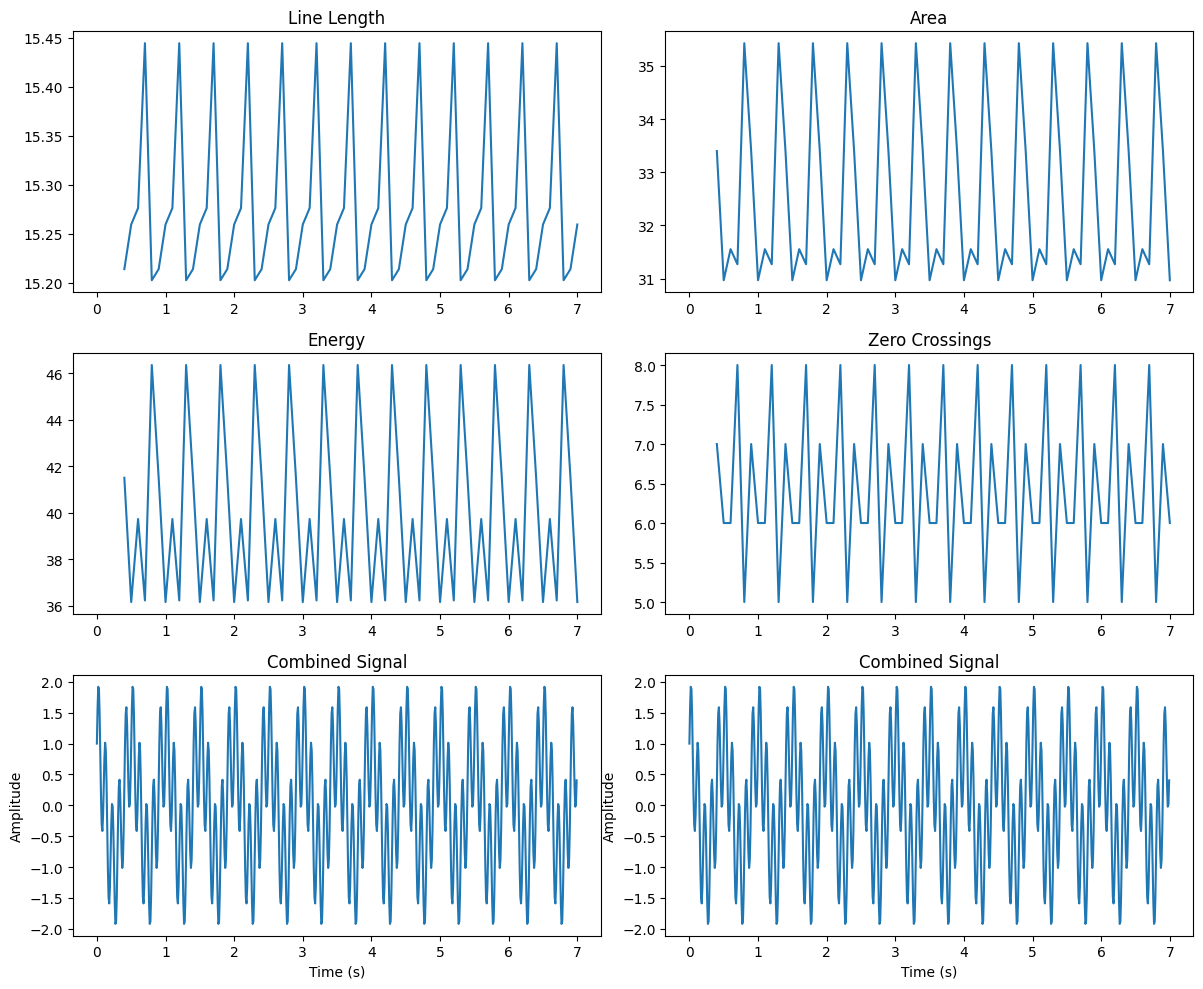

In [111]:
# Your code here
ll_combined = MovingWinFeats(combined_signal, 100, 0.4, 0.1, line_length)
area_combined = MovingWinFeats(combined_signal, 100, 0.4, 0.1, area)
energy_combined = MovingWinFeats(combined_signal, 100, 0.4, 0.1, energy)
zero_crossings_combined = MovingWinFeats(combined_signal, 100, 0.4, 0.1, zero_crossings)
feature_time = np.arange(0.4, 7 + 0.1, 0.1)

fig, axs = plt.subplots(3, 2, figsize=(12, 10))

## signal in bottom plots
axs[2, 0].plot(time, combined_signal)
axs[2, 0].set_title('Combined Signal')
axs[2, 0].set_xlabel('Time (s)')
axs[2, 0].set_ylabel('Amplitude')

axs[2, 1].plot(time, combined_signal)
axs[2, 1].set_title('Combined Signal')
axs[2, 1].set_xlabel('Time (s)')
axs[2, 1].set_ylabel('Amplitude')

xlimits = axs[2, 0].get_xlim()

## ll in top left
axs[0, 0].plot(feature_time, ll_combined)
axs[0, 0].set_title('Line Length')
axs[0, 0].set_xlim(xlimits)

## area top right
axs[0, 1].plot(feature_time, area_combined)
axs[0, 1].set_title('Area')
axs[0, 1].set_xlim(xlimits)

## energy middle left
axs[1, 0].plot(feature_time, energy_combined)
axs[1, 0].set_title('Energy')
axs[1, 0].set_xlim(xlimits)

## zero crossings middle right
axs[1, 1].plot(feature_time, zero_crossings_combined)
axs[1, 1].set_title('Zero Crossings')
axs[1, 1].set_xlim(xlimits)

plt.tight_layout()
plt.show()

## 2. Feature Overlays (17 pts)
In this section, you will use a line-length feature overlay on a segment of EEG containing a seizure. This data is stored in I521_A0003_D001.

### 1
What is the length using hrs:min:sec.ms of the recording?
You may find [`divmod`](https://docs.python.org/3/library/functions.html) to be helpful. Also, the `time` and `datetime` packages are imported and can also be used. (2 pts)

In [112]:
# Your code here

streamer = PennsieveStreamer()
streamer.set_dataset("N:dataset:cf2376f0-aede-4c3c-b6a7-0cefded0d64c")
streamer.set_package("N:package:f6b741bd-3837-4606-8e70-f429205cee53")

Connecting to Pennsieve Agent at localhost:9002...
Successfully connected to Pennsieve Agent.
Resolving dataset ID: N:dataset:cf2376f0-aede-4c3c-b6a7-0cefded0d64c
Found dataset: 'Homework Data'
Active dataset set to: Homework Data
Active package set to: N:package:f6b741bd-3837-4606-8e70-f429205cee53


In [113]:
metadata = streamer.get_metadata()
total_time_seconds = (metadata['channels'][0]['end_time'] - metadata['channels'][0]['start_time']) / 1e6
print(f"Total time in seconds: {total_time_seconds:.4f}")

# print time in hrs:min:sec:ms:
hours, remainder = divmod(total_time_seconds, 3600)
minutes, seconds = divmod(remainder, 60)
_, milliseconds = divmod(remainder, 1)

hours = int(hours)
minutes = int(minutes)
seconds = int(round(seconds, 8))
milliseconds = int(round(milliseconds * 1000, 8))

print("hrs:min:sec:ms")
print(f"{hours}:{minutes}:{seconds}:{milliseconds}")

Total time in seconds: 4880.9950
hrs:min:sec:ms
1:21:20:995


```1:21:20:995```

### 2
How many data points should we discard at the end if we want to clip the recording to the last full second? Do this clipping. (1 pt)

In [114]:
# Your code here
print(milliseconds / 1000 * metadata['channels'][0]['rate_hz'])

clip = streamer.get_clip(0, 4880)

199.0


```199 samples should be discarded. ```

### 3
If we want to overlay a feature trace on the original signal, we have to interpolate that feature (which has been calculated over windows) for each data point of the original signal. One of the simplest methods of doing this is called zero-order interpolation, where we just hold the value constant until we
get to the next calculated value. For example, if we had a moving window of 1 second with 1 second displacement, the zero-order interpolated feature vector would have the same value the entire 1s5 second, then the same for the entire 2nd second, etc, where each second contains the same number of points as the sampling frequency of the original signal.

####3a
Using the [`np.tile`](https://numpy.org/doc/stable/reference/generated/numpy.tile.html) and [`np.reshape`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) functions, create an external function `zoInterp(x, numInterp)` that copies each value of `x` `numInterp` times. For `np.reshape`, setting `order='F'` may be necessary. You can implement this function in one line. (2 pts)

In [115]:
# Your code here
def zoInterp(x, numInterp):
  return np.reshape(np.tile(x, (numInterp, 1)), -1, order='F')

####3b
Confirm that this function works correctly by expanding the length of the vector `[1, 2, 3, 4, 5]` by a factor of 5. Plot your results using the `-o` plotting option to let us see the individual points and the line that connects them. (2 pts)

> Hint: your resulting vector should be a column vector of [1,1,1,1,1,2,2,2,...]

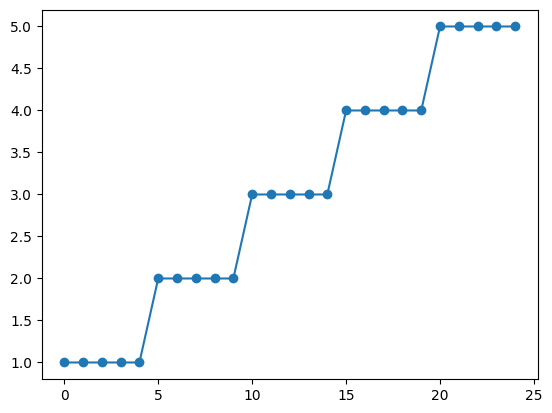

In [116]:
# Your code here
expanded = zoInterp([1, 2, 3, 4, 5], 5)

plt.plot(expanded, '-o')
plt.show()

### 4
Using a 5-second sliding window with 1-second displacement, calculate the line-length feature over the entire signal. Normalize the line-length feature values to have a maximum twice that of the original EEG signal maximum. Plot the signal in blue and overlay the right-aligned line-length feature in yellow.
Note: you will need to [pad](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) your signal in order to get them to line up correctly and be the same length. Be sure to add a legend in a location in the plot that does not cover up any signal or feature. (6 pts)

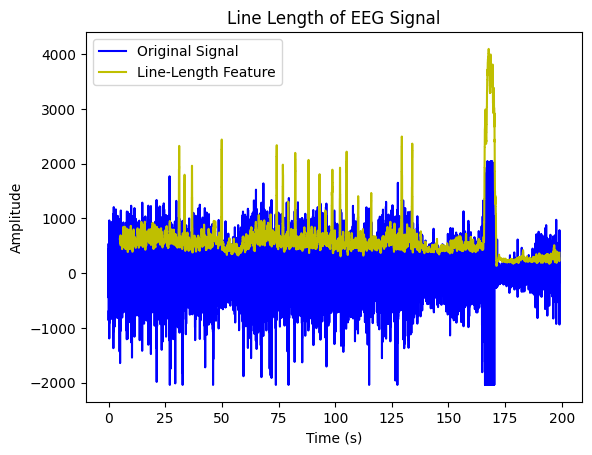

In [117]:
# Your code here
signal = np.array(clip.szChirps)
time_signal = np.linspace(0, 199, len(signal))
fs = int(metadata['channels'][0]['rate_hz'])

ll_signal = MovingWinFeats(signal, fs, 5, 1, line_length)
ll_signal_normalized = ll_signal * np.max(clip) / np.max(ll_signal) * 2
ll_signal_normalized = zoInterp(ll_signal_normalized, fs * 1)
time_ll_interp = np.linspace(5, 199, len(ll_signal_normalized))

# plotting
plt.plot(time_signal, signal, 'b')
plt.plot(time_ll_interp, ll_signal_normalized, 'y')
plt.legend(['Original Signal', 'Line-Length Feature'])
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Line Length of EEG Signal')
plt.show()

### 5
What threshold might you use on the raw line-length feature vector (not the normalized one used for plotting) in order to capture the 17 largest pre-seizure chirps that occur? (1 pt)

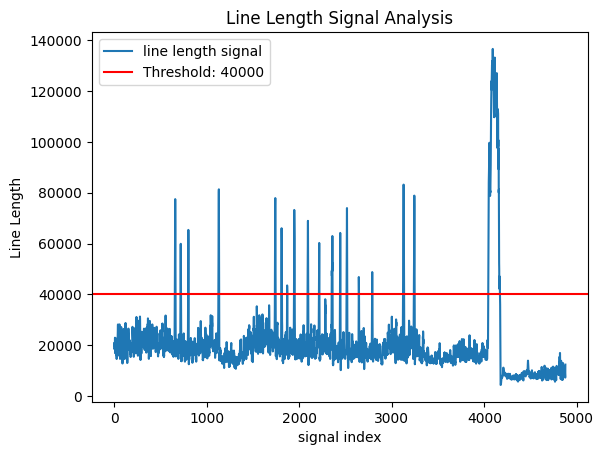

In [118]:
# Your code here
plt.plot(ll_signal, label="line length signal")
plt.axhline(y=40000, color='r', linestyle='-', label="Threshold: 40000")
plt.legend()
plt.title("Line Length Signal Analysis")
plt.xlabel("signal index")
plt.ylabel("Line Length")
plt.show()


```A threshold of 40_000 works well. ```

### 6
Using this threshold value, in another plot draw red [vertical](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.vlines.html#matplotlib.pyplot.vlines) dashed lines at the leading point in time where the threshold is crossed. Add these vertical lines on top of the plot you made in Question 2.4. These events should capture the pre-seizure chirps, the seizure onset, and some flickering during the end of the seizure. (3 pts)

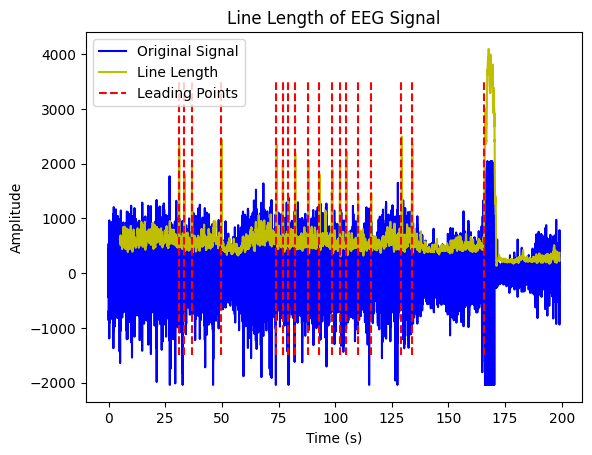

In [119]:
# Your code here

# Identify leading points at which line length > 40_000
leading_points = np.where(ll_signal > 40_000)[0]
time_ll = np.linspace(5, 199, len(ll_signal))
leading_points_times = time_ll[leading_points]
first_leading_points_times = []
for i in range(len(leading_points_times)):
  if i == 0:
    first_leading_points_times.append(leading_points_times[i])
  else:
    if leading_points_times[i] - leading_points_times[i-1] > 1:
      first_leading_points_times.append(leading_points_times[i])

# plotting
plt.plot(time_signal, signal, 'b', label="Original Signal")
plt.plot(time_ll_interp, ll_signal_normalized, 'y', label="Line Length")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Line Length of EEG Signal')
plt.vlines(first_leading_points_times, -1500, 3500, colors='r', linestyles='dashed', label='Leading Points')
plt.legend()
plt.show()

## 3. Building a Detector (12 pts)

In this section, you will use the features you defined previously to build a seizure detector. Use the EEG data in the file I521_A0003_D002 with channels multiSz_1, and multiSz_2.

### 1
Plot the signal in multiSz_1 and draw vertical dashed red lines at the times when you think the two seizures begin. You should be able to do this without the need of any features. (2 pts)

In [120]:
streamer.set_package("N:package:7e684e91-806e-4810-b0c1-4318b6069a7a")
metadata = streamer.get_metadata()

Active package set to: N:package:7e684e91-806e-4810-b0c1-4318b6069a7a


In [121]:
# Your code here
total_time_seconds = (metadata['channels'][1]['end_time'] - metadata['channels'][1]['start_time']) / 1e6
print(f"Total time in seconds: {total_time_seconds:.4f}")

Total time in seconds: 14999.9950


In [122]:
multiSz_1 = streamer.get_clip(0, 14999)['multiSz_1']

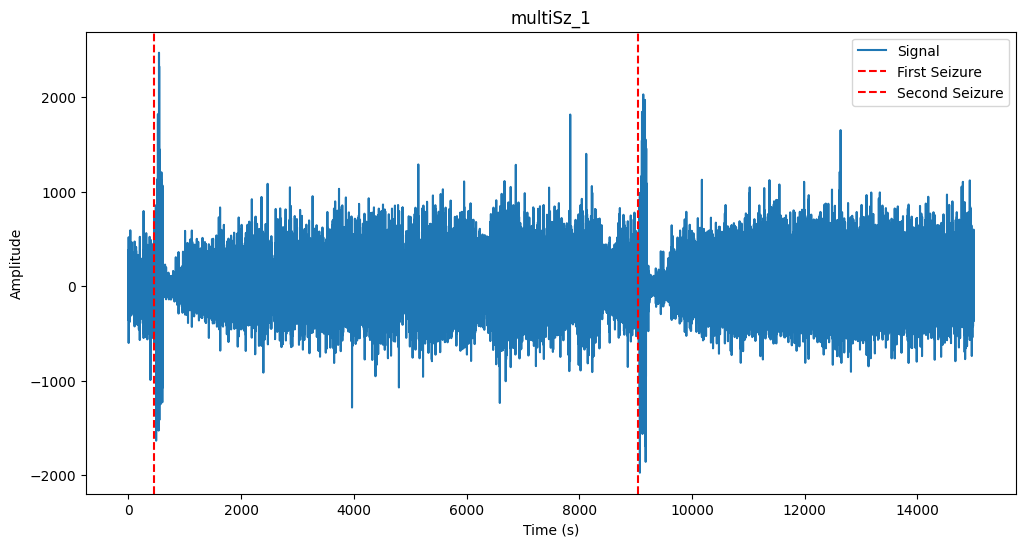

In [123]:
time = np.linspace(0, 14999, len(multiSz_1))
plt.figure(figsize=(12, 6))
plt.plot(time, multiSz_1, label="Signal")
plt.axvline(x=450, color='r', linestyle='--', label="First Seizure")
plt.axvline(x=9050, color='r', linestyle='--', label="Second Seizure")
plt.title('multiSz_1')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### 2
Produce feature overlay plots similar to that of Question 2.4 for each of the four features you have implemented along with the red vertical dashed lines at each seizure. Use a 4-second sliding window with 1 second displacement. (4 pts)

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


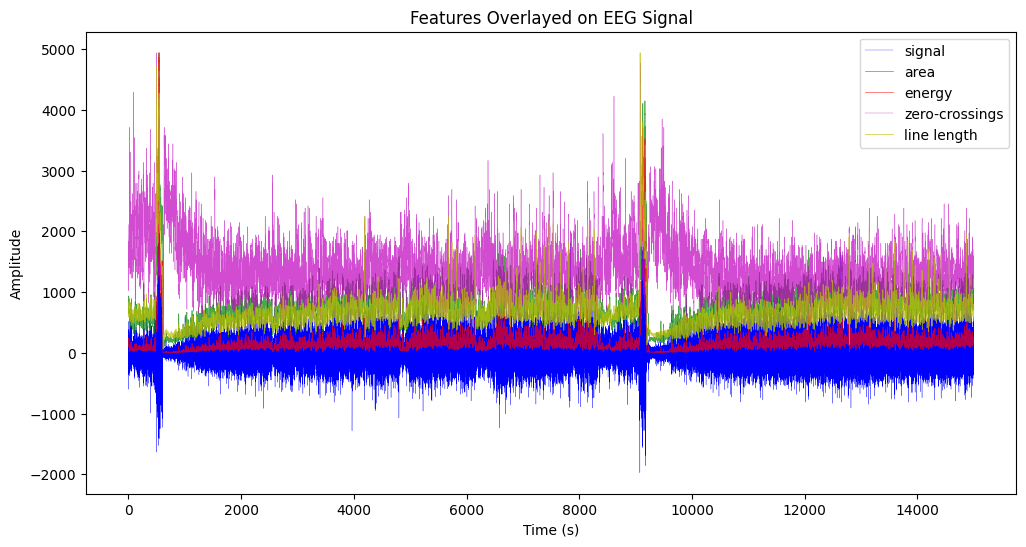

In [124]:
# Your code here
signal = np.array(multiSz_1)
time_signal = np.linspace(0, 14999, len(signal))
fs = int(metadata['channels'][1]['rate_hz'])

ll_signal = MovingWinFeats(signal, fs, 4, 1, line_length)
ll_signal_normalized = ll_signal * np.max(multiSz_1) / np.max(ll_signal) * 2
ll_signal_normalized = zoInterp(ll_signal_normalized, fs * 1)

area_signal = MovingWinFeats(signal, fs, 4, 1, area)
area_signal_normalized = area_signal * np.max(multiSz_1) / np.max(area_signal) * 2
area_signal_normalized = zoInterp(area_signal_normalized, fs * 1)

energy_signal = MovingWinFeats(signal, fs, 4, 1, energy)
energy_signal_normalized = energy_signal * np.max(multiSz_1) / np.max(energy_signal) * 2
energy_signal_normalized = zoInterp(energy_signal_normalized, fs * 1)

zero_crossings_signal = MovingWinFeats(signal, fs, 4, 1, zero_crossings)
zero_crossings_signal_normalized = zero_crossings_signal * np.max(multiSz_1) / np.max(zero_crossings_signal) * 2
zero_crossings_signal_normalized = zoInterp(zero_crossings_signal_normalized, fs * 1)

time_features_interp = np.linspace(4, 14999, len(ll_signal_normalized))

# plotting
plt.figure(figsize=(12, 6))
plt.plot(time_signal, signal, 'b', linewidth=0.2, label="signal")
plt.plot(time_features_interp, area_signal_normalized, 'g', linewidth=0.5, label="area", alpha=0.7)
plt.plot(time_features_interp, energy_signal_normalized, 'r', linewidth=0.5, label="energy", alpha=0.7)
plt.plot(time_features_interp, zero_crossings_signal_normalized, 'm', linewidth=0.3, label="zero-crossings", alpha=0.7)
plt.plot(time_features_interp, ll_signal_normalized, 'y', linewidth=0.6, label="line length", alpha=0.7) # rearranged for overlay clarity
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Features Overlayed on EEG Signal')
plt.show()

### 3

####3a
Based on your plots in the previous question, which of the four features seems to give the largest signal (relative to the background) for when a  seizure occurs? Explain why you think this feature is the best. (3 pts)

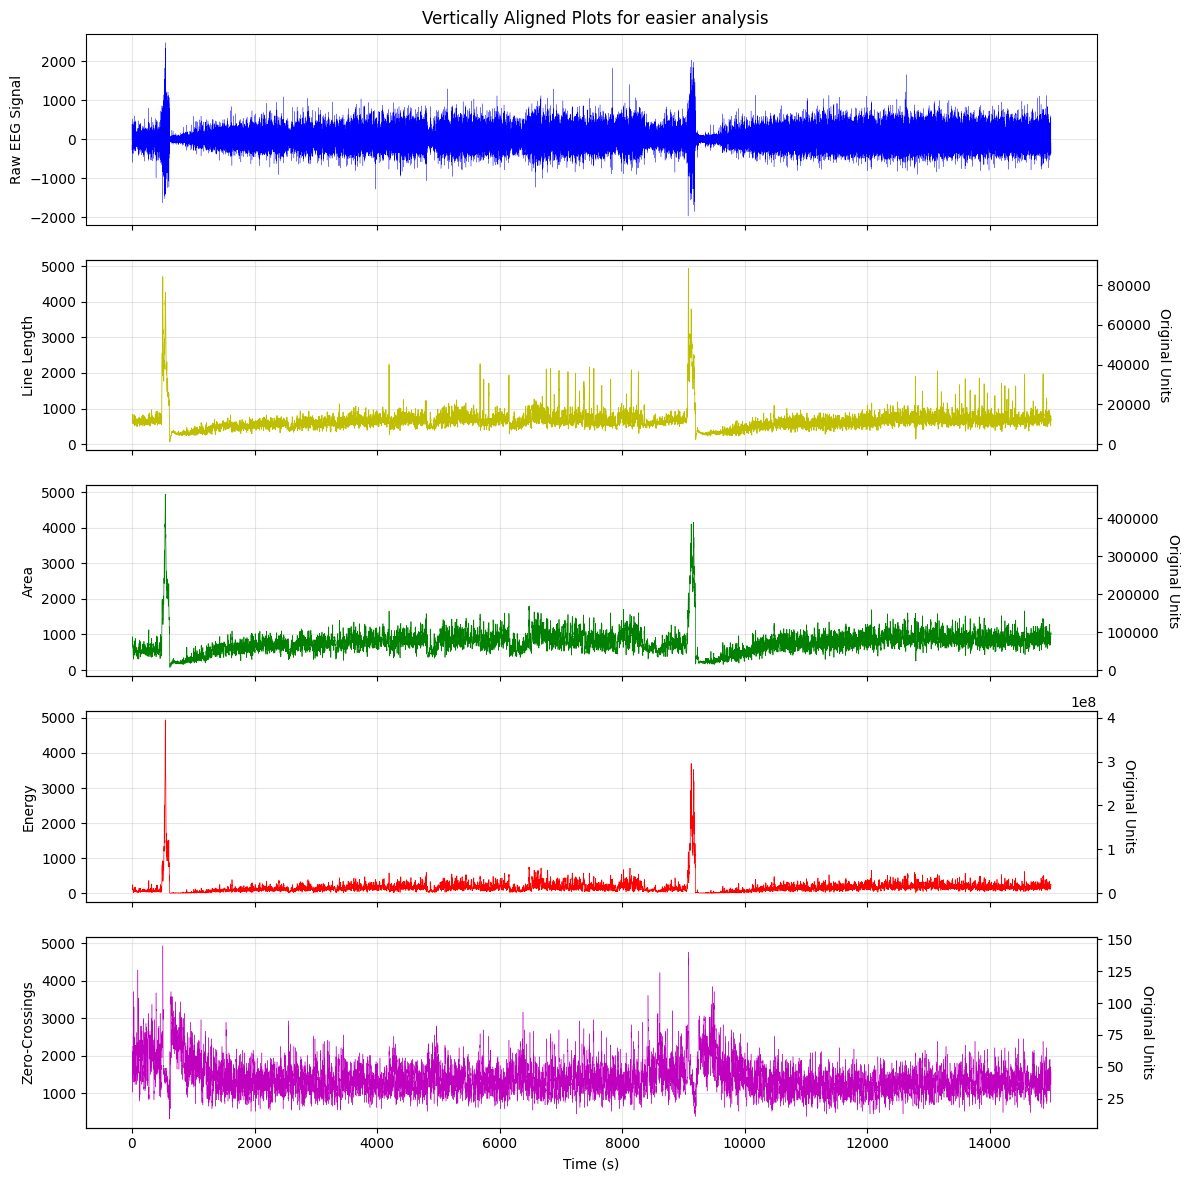

In [125]:
ll_signal_interp = zoInterp(ll_signal, fs * 1)
area_signal_interp = zoInterp(area_signal, fs * 1)
energy_signal_interp = zoInterp(energy_signal, fs * 1)
zero_crossings_signal_interp = zoInterp(zero_crossings_signal, fs * 1)

fig, axs = plt.subplots(5, 1, figsize=(12, 12), sharex=True)
fig.suptitle("Vertically Aligned Plots for easier analysis")

# Raw Signal
axs[0].plot(time_signal, signal, 'b', linewidth=0.2)
axs[0].set_ylabel('Raw EEG Signal')
axs[0].grid(True, alpha=0.3)

# Line Length
axs[1].plot(time_features_interp, ll_signal_normalized, 'y', linewidth=0.6)
axs[1].set_ylabel('Line Length')
axs[1].grid(True, alpha=0.3)

ax1_right = axs[1].twinx()
ax1_right.plot(time_features_interp, ll_signal_interp, 'y', alpha=0) # Invisible plot to set scale
ax1_right.set_ylabel('Original Units', rotation=270, labelpad=15)
ax1_right.tick_params(axis='y', labelcolor='k')

# Area
axs[2].plot(time_features_interp, area_signal_normalized, 'g', linewidth=0.5)
axs[2].set_ylabel('Area')
axs[2].grid(True, alpha=0.3)

ax2_right = axs[2].twinx()
ax2_right.plot(time_features_interp, area_signal_interp, 'g', alpha=0)
ax2_right.set_ylabel('Original Units', rotation=270, labelpad=15)
ax2_right.tick_params(axis='y', labelcolor='k')

# Energy
axs[3].plot(time_features_interp, energy_signal_normalized, 'r', linewidth=0.5)
axs[3].set_ylabel('Energy')
axs[3].grid(True, alpha=0.3)

ax3_right = axs[3].twinx()
ax3_right.plot(time_features_interp, energy_signal_interp, 'r', alpha=0)
ax3_right.set_ylabel('Original Units', rotation=270, labelpad=15)
ax3_right.tick_params(axis='y', labelcolor='k')
# ax3_right.axhline(true_threshold)

# Zero-Crossings
axs[4].plot(time_features_interp, zero_crossings_signal_normalized, 'm', linewidth=0.3)
axs[4].set_ylabel('Zero-Crossings')
axs[4].set_xlabel('Time (s)')
axs[4].grid(True, alpha=0.3)

ax4_right = axs[4].twinx()
ax4_right.plot(time_features_interp, zero_crossings_signal_interp, 'm', alpha=0)
ax4_right.set_ylabel('Original Units', rotation=270, labelpad=15)
ax4_right.tick_params(axis='y', labelcolor='k')

plt.tight_layout()
plt.show()

For determining when a seizure is actively occuring, I'd use the **energy** feature. Compared to line length and area, the difference between normal (and during the pre-seizure chirps) versus the during-seizure signal is greater in energy. Line length has chrips that extend to 2000 units, almost half of the peak signal around 4500. Area has resting signal between 500 and 1800, compared to signal at 4000 (but the signal stays around 400 for a while during seizure, unlike line length). Also about a one-half ratio. Energy has peaks at 5000 and 3700, but the resting signal is barely at 500 and the pre-seizure signal is only around 800. This gives you a magnitude difference of about 4 to 5x, which makes the classification boundary more obvious. Zero-crossings is least useful, since the peak heights are about the same at all times, and seizures are characterized by a sustained drop in zero-crossings, however, this isn't useful with a threshold since regular signal also has drops in zero-crossing. A larger window would be necessary to extract this drop in zero-crossings. *Note that these units given were from normalized signals*.

####3b
What threshold would you use to determine if a seizure is occurring? (1 pt)

In [126]:
# Your code here
normalized_threshold = 1000
true_threshold = 1000 * np.max(energy_signal) / np.max(multiSz_1) / 2
true_threshold

np.float64(79916479.84218588)

```Energy > 7.48 * 10^7. On the normalized signal, this is a threshold of 1000. Any threshold between 800 and 3000 seems sufficient, but 1000 provides an early recognition of seizure onset while avoiding false positives. ```

### 4
The signal in multiSz_2 contains another seizure (whose location should again be fairly obvious). Plot the data along with the feature and threshold (horizontal black line, with correct normalization for the signal in data2) you determined in the previous question. (2 pts)

In [127]:
# Your code here
total_time_seconds = (metadata['channels'][0]['end_time'] - metadata['channels'][0]['start_time']) / 1e6
print(f"Total time in seconds: {total_time_seconds:.4f}")
multiSz_2 = streamer.get_clip(0, 14999)['multiSz_2']

Total time in seconds: 14999.9950


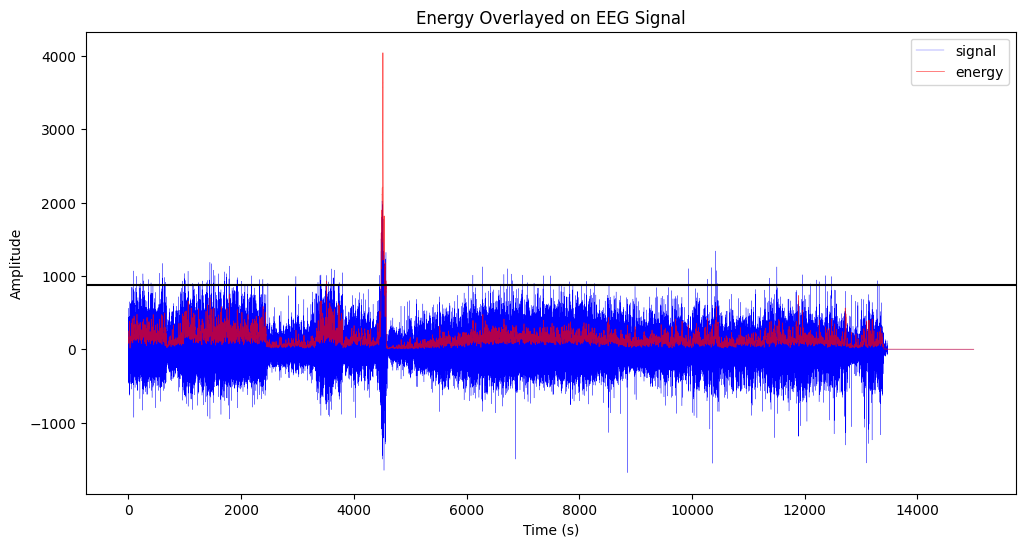

In [128]:
signal = np.array(multiSz_2)
time_signal = np.linspace(0, 14999, len(signal))
fs = int(metadata['channels'][1]['rate_hz'])

energy_signal = MovingWinFeats(signal, fs, 4, 1, energy)
energy_signal_normalized = energy_signal * np.max(multiSz_2) / np.max(energy_signal) * 2
energy_signal_normalized = zoInterp(energy_signal_normalized, fs * 1)

time_features_interp = np.linspace(4, 14999, len(energy_signal_normalized))

# plotting
plt.figure(figsize=(12, 6))
plt.plot(time_signal, signal, 'b', linewidth=0.2, label="signal")
plt.plot(time_features_interp, energy_signal_normalized, 'r', linewidth=0.5, label="energy", alpha=0.7)
plt.axhline(true_threshold * 2 * np.max(multiSz_2) / np.max(energy_signal), color='black')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Energy Overlayed on EEG Signal')
plt.show()

as a note, I do think this only worked because the two signal's maximum (seizure signal peak height) and average resting signal (~median) are relatively similar. Otherwise, I think a better signal would be the ratio of the current energy to the median energy. However, this means tuning per patient and collecting a median energy in advance. This is also extra difficult since these clips contain the pre-seizure extra energy.

In [129]:
print(np.median(multiSz_1))
print(np.max(multiSz_1))
print(np.median(multiSz_2))
print(np.max(multiSz_2))

0.9980926513671875
2469.93212890625
-0.01907377690076828
2020.9549560546875
